In [1]:
import pennylane as qml
from pennylane import numpy as np
import matplotlib.pyplot as plt

In [2]:
"Setting up main Hyper-Parameters of the model"

n_qubits = 3  # Number of system qubits.
n_shots = 10 ** 6  # Number of quantum measurements.
tot_qubits = n_qubits + 1  # Addition of an ancillary qubit.
ancilla_idx = n_qubits  # Index of the ancillary qubit (last position).
steps = 100  # Number of optimization steps
eta = 0.8  # Learning rate
q_delta = 0.001  # Initial spread of random quantum weights
rng_seed = 0  # Seed for random number generator


In [3]:
#Fundemental Quantum Pauli Matrices 
Id = np.identity(2) #identity matrix of 2 rows
Z = np.array([[1, 0], [0, -1]]) 
X = np.array([[0, 1], [1, 0]])
Y = np.array([[0,complex(0,1)],[-complex(0,1),0]])

In [4]:
gate_array = [Id,X,Y,Z]
gate_array_names = ["Id","X","Y","Z"]

### Linear System $Ax = b$

In [6]:
A_0 = np.identity(8)
A_1 = np.kron(np.kron(X, Z), Id)
#A_2 = np.kron(np.kron(X, Id), Id)
#A_3 = np.kron(np.kron(Z, Z), Id)

#Ax = b
A = 1 * A_0 + 0.4 * A_1 
b = np.ones(8) / np.sqrt(8)

In [7]:
A

tensor([[ 1. ,  0. ,  0. ,  0. ,  0.4,  0. ,  0. ,  0. ],
        [ 0. ,  1. ,  0. ,  0. ,  0. ,  0.4,  0. ,  0. ],
        [ 0. ,  0. ,  1. ,  0. ,  0. ,  0. , -0.4,  0. ],
        [ 0. ,  0. ,  0. ,  1. ,  0. ,  0. ,  0. , -0.4],
        [ 0.4,  0. ,  0. ,  0. ,  1. ,  0. ,  0. ,  0. ],
        [ 0. ,  0.4,  0. ,  0. ,  0. ,  1. ,  0. ,  0. ],
        [ 0. ,  0. , -0.4,  0. ,  0. ,  0. ,  1. ,  0. ],
        [ 0. ,  0. ,  0. , -0.4,  0. ,  0. ,  0. ,  1. ]], requires_grad=True)

#### Get Coefficients of Linear Combination of Puali Matrices

In [8]:
counter = 0
i = 0

combination = gate_array

while counter < np.log2(len(A)) - 1:

    combination = np.kron(combination, gate_array)
    
    counter += 1

In [9]:
counter = 0
i = 0

combination_names = gate_array_names
temp_array_names = gate_array_names

for i in range(len(gate_array_names)):
    None

In [10]:
np.log2(len(A))

3.0

In [11]:
final_array = np.zeros((len(A),len(A)), dtype=complex)
c = []

for i in range(len(combination)):
    c_temp =  1/(len(A)) * np.matrix.trace(np.matmul(A,combination[i]))
    c.append(c_temp)
    final_array +=  c_temp * combination[i]

In [12]:
print(final_array.real)

[[ 1.   0.   0.   0.   0.4  0.   0.   0. ]
 [ 0.   1.   0.   0.   0.   0.4  0.   0. ]
 [ 0.   0.   1.   0.   0.   0.  -0.4  0. ]
 [ 0.   0.   0.   1.   0.   0.   0.  -0.4]
 [ 0.4  0.   0.   0.   1.   0.   0.   0. ]
 [ 0.   0.4  0.   0.   0.   1.   0.   0. ]
 [ 0.   0.  -0.4  0.   0.   0.   1.   0. ]
 [ 0.   0.   0.  -0.4  0.   0.   0.   1. ]]


In [13]:
c = np.array(c)

In [14]:
c = c[c != 0]

In [15]:
c

tensor([1. +0.j, 0.4+0.j], requires_grad=True)

In [15]:
#controlled_gate_array = [1,CNOT,CY,CZ]
#Have to think of a clever way of combining the array to work out nicely - something that would reduce the zeros first

In [16]:
def U_b():
    """Unitary matrix rotating the ground state to the problem vector |b> = U_b |0>."""
    for idx in range(n_qubits):
        qml.Hadamard(wires=idx)

def CA(idx):
    """Controlled versions of the unitary components A_l of the problem matrix A."""
    if idx == 0:
        # Identity operation
        None

    elif idx == 1:
        qml.CNOT(wires=[ancilla_idx, 0])
#     elif idx == 2:
#         qml.CNOT(wires=[ancilla_idx, 0])
#         qml.CZ(wires=[ancilla_idx, 1])
#     elif idx == 3:
#         qml.CZ(wires=[ancilla_idx, 0])
#         qml.CZ(wires=[ancilla_idx, 1])

In [17]:
def variational_block(weights):
    """Variational circuit mapping the ground state |0> to the ansatz state |x>."""
    
    # We first prepare an equal superposition of all the states of the computational basis.
    for idx in range(n_qubits):
        qml.Hadamard(wires=idx)

    # A very minimal variational circuit.
    # just a single layer of qubit rotations around y
    # can make more complex 
    for idx, element in enumerate(weights):
        qml.RY(element, wires=idx)
        
        
    #return qml.expval(qml.PauliZ(0)) 
    ## don't actually want to return anything, just there to visualize for now
      
weights = np.random.random(size=4)
drawer = qml.draw(variational_block)

In [18]:
"Example of more complicated circuit using Pennylane StronglyEntaglingLayers, this is for later"
"Let's first get the RY circuit working"

dev = qml.device('default.qubit', wires=4)

@qml.qnode(dev)
def circuit(parameters):
    for idx in range(4):
        qml.Hadamard(wires=idx)
    
    qml.StronglyEntanglingLayers(weights=parameters, wires=range(4))
    return qml.expval(qml.PauliZ(0))

shape = qml.StronglyEntanglingLayers.shape(n_layers=2, n_wires=4)
weights = np.random.random(size=shape)

print(qml.draw(circuit, expansion_strategy="device")(weights))

0: ──H──Rot(0.59,0.54,0.71)─╭●───────╭X──Rot(0.61,0.23,0.36)─╭●────╭X────┤  <Z>
1: ──H──Rot(0.93,0.34,0.82)─╰X─╭●────│───Rot(0.66,0.10,0.91)─│──╭●─│──╭X─┤     
2: ──H──Rot(0.97,0.46,0.38)────╰X─╭●─│───Rot(0.74,0.37,0.26)─╰X─│──╰●─│──┤     
3: ──H──Rot(0.61,0.70,0.32)───────╰X─╰●──Rot(0.61,0.02,0.83)────╰X────╰●─┤     


In [19]:
dev_mu = qml.device("default.qubit", wires=tot_qubits)

@qml.qnode(dev_mu)
def local_hadamard_test(weights, l=None, lp=None, j=None, part=None):

    # First Hadamard gate applied to the ancillary qubit.
    qml.Hadamard(wires=ancilla_idx)

    # For estimating the imaginary part of the coefficient "mu", we must add a "-i"
    # phase gate.
    if part == "Im" or part == "im":
        qml.PhaseShift(-np.pi / 2, wires=ancilla_idx)

    # Variational circuit generating a guess for the solution vector |x>
    variational_block(weights)

    # Controlled application of the unitary component A_l of the problem matrix A.
    CA(l)

    # Adjoint of the unitary U_b associated to the problem vector |b>.
    # In this specific example Adjoint(U_b) = U_b.
    U_b()

    # Controlled Z operator at position j. If j = -1, apply the identity.
    if j != -1:
        qml.CZ(wires=[ancilla_idx, j])

    # Unitary U_b associated to the problem vector |b>.
    U_b()

    # Controlled application of Adjoint(A_lp).
    # In this specific example Adjoint(A_lp) = A_lp.
    CA(lp)

    # Second Hadamard gate applied to the ancillary qubit.
    qml.Hadamard(wires=ancilla_idx)

    # Expectation value of Z for the ancillary qubit.
    return qml.expval(qml.PauliZ(wires=ancilla_idx))

In [20]:
print(qml.draw(local_hadamard_test)(weights=[1.2, 3.2, 0.7]))

   0: ──H──RY(1.20)──H──H─┤     
   1: ──H──RY(3.20)──H──H─┤     
   2: ──H──RY(0.70)──H──H─┤     
   3: ──H─╭●─────────H────┤  <Z>
None: ────╰Z──────────────┤     


In [21]:
def mu(weights, l=None, lp=None, j=None):
    """Generates the coefficients to compute the "local" cost function C_L."""

    mu_real = local_hadamard_test(weights, l=l, lp=lp, j=j, part="Re")
    mu_imag = local_hadamard_test(weights, l=l, lp=lp, j=j, part="Im")

    return mu_real + 1.0j * mu_imag

#### Local Cost Function
Need a function to estimate $<x|A^\dagger A|x>$

In [22]:
def psi_norm(weights):
    """Returns the normalization constant <psi|psi>, where |psi> = A |x>."""
    norm = 0.0

    for l in range(0, len(c)):
        for lp in range(0, len(c)):
            norm = norm + c[l] * np.conj(c[lp]) * mu(weights, l, lp, -1)

    return abs(norm)

In [23]:
def cost_loc(weights):
    """Local version of the cost function. Tends to zero when A|x> is proportional to |b>."""
    mu_sum = 0.0

    for l in range(0, len(c)):
        for lp in range(0, len(c)):
            for j in range(0, n_qubits):
                mu_sum = mu_sum + c[l] * np.conj(c[lp]) * mu(weights, l, lp, j)

    mu_sum = abs(mu_sum)

    # Cost function C_L
    return 0.5 - 0.5 * mu_sum / (n_qubits * psi_norm(weights))

#### Variational Optimization

In [24]:
#Intialize the weights with a fix seed

np.random.seed(rng_seed)
w = q_delta * np.random.randn(n_qubits, requires_grad=True)

In [25]:
#classical optimizer to minimize the cost function

opt = qml.GradientDescentOptimizer(eta)
#opt = qml.jacobian(eta)
#opt - qml.elementwise_grad(eta)
#opt = qml.holomorphic_grad(eta)

In [26]:
cost_history = []
for it in range(steps):
    w, cost = opt.step_and_cost(cost_loc, w)
    print("Step {:3d}       Cost_L = {:9.7f}".format(it, cost))
    cost_history.append(cost)

Step   0       Cost_L = 0.0000001
Step   1       Cost_L = 0.0000001
Step   2       Cost_L = 0.0000001
Step   3       Cost_L = 0.0000001
Step   4       Cost_L = 0.0000001
Step   5       Cost_L = 0.0000001
Step   6       Cost_L = 0.0000001
Step   7       Cost_L = 0.0000000
Step   8       Cost_L = 0.0000000
Step   9       Cost_L = 0.0000000
Step  10       Cost_L = 0.0000000
Step  11       Cost_L = 0.0000000
Step  12       Cost_L = 0.0000000
Step  13       Cost_L = 0.0000000
Step  14       Cost_L = 0.0000000
Step  15       Cost_L = 0.0000000
Step  16       Cost_L = 0.0000000
Step  17       Cost_L = 0.0000000
Step  18       Cost_L = 0.0000000
Step  19       Cost_L = 0.0000000
Step  20       Cost_L = 0.0000000
Step  21       Cost_L = 0.0000000
Step  22       Cost_L = 0.0000000
Step  23       Cost_L = 0.0000000
Step  24       Cost_L = 0.0000000
Step  25       Cost_L = 0.0000000
Step  26       Cost_L = 0.0000000
Step  27       Cost_L = 0.0000000
Step  28       Cost_L = 0.0000000
Step  29      

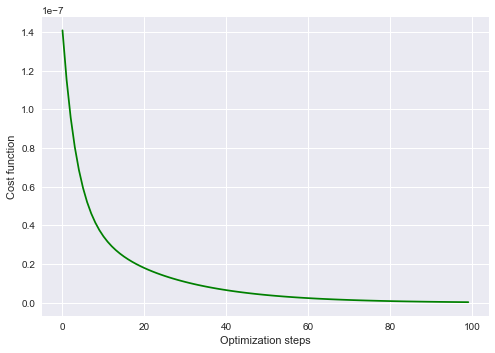

In [27]:
plt.style.use("seaborn")
plt.plot(cost_history, "g")
plt.ylabel("Cost function")
plt.xlabel("Optimization steps")
plt.show()

#### Preparation of Quantum Solution

In [28]:
dev_x = qml.device("default.qubit", wires=n_qubits, shots=n_shots)

@qml.qnode(dev_x)
def prepare_and_sample(weights):

    # Variational circuit generating a guess for the solution vector |x>
    variational_block(weights)

    # We assume that the system is measured in the computational basis.
    # then sampling the device will give us a value of 0 or 1 for each qubit (n_qubits)
    # this will be repeated for the total number of shots provided (n_shots)
    return qml.sample()

In [29]:
raw_samples = prepare_and_sample(w)

# convert the raw samples (bit strings) into integers and count them
samples = []
for sam in raw_samples:
    samples.append(int("".join(str(bs) for bs in sam), base=2))

q_probs = np.bincount(samples) / n_shots


In [30]:
print("|<x|n>|^2=\n", q_probs)

|<x|n>|^2=
 [0.125125 0.124488 0.124642 0.124869 0.125375 0.124684 0.125628 0.125189]


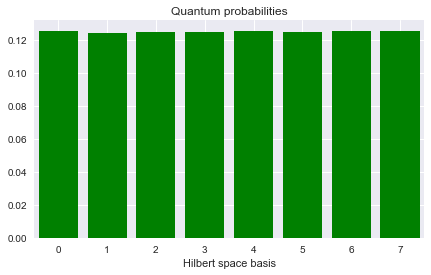

In [31]:
fig, ax2 = plt.subplots(1, figsize=(7, 4))

ax2.bar(np.arange(0, 2 ** n_qubits), q_probs, color="green")
ax2.set_xlim(-0.5, 2 ** n_qubits - 0.5)
ax2.set_xlabel("Hilbert space basis")
ax2.set_title("Quantum probabilities")

plt.show()

In [32]:
A_inv = np.linalg.inv(A)
x = np.dot(A_inv, b)

In [33]:
c_probs = (x / np.linalg.norm(x)) ** 2
print("x_n^2 =\n", c_probs)

x_n^2 =
 [0.0387931 0.0387931 0.2112069 0.2112069 0.0387931 0.0387931 0.2112069
 0.2112069]
